# Projet 4 : Anticipez les besoins en consommation de bâtiments<br>- Prédiction des émissions de CO2
## Sommaire
* [Importation des bibliothèques](#import_bib)
* [Chargement de l'ensemble de données nettoyé](#charg_donn)
* [Chargement de l'ensemble de données nettoyé](#charg_donn)
* [Préparation des dataframes avec divers traitements du score ENERGYSTAR manquant](#prep_dfs_enstr_manq)
    * [Traitements sans imputation](#trait_sans_imput)
    * [Imputation des valeurs manquantes et sauvegarde des dataframes traités](#imput_et_sauv)
    * [Comparaison de la distribution du caractéristique ENERGYSTAR avec et sans valeurs imputées](#comp_enstr_avec_sans_imput)
* [Construction d'un pipeline de prétraitement](#constr_pipe)
* [Utilisation d'un régresseur factice pour établir des indicateurs de base de référence](#reg_factice)
* [Remarques sur les fuites de données](#ramarq_fuit_donn)
* [Sélection automatique des caractéristiques](#sel_auto_caract)
* [Modèle de régression linéaire](#mod_reg_lin)

    
## Importation des bibliothèques <a class="anchor" id="import_bib"></a>

In [43]:
import graphviz
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import pickle
import random
from scipy import stats
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    confusion_matrix,
    make_scorer,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import xgboost as xgb


## Chargement de l'ensemble de données nettoyé <a class="anchor" id="charg_donn"></a>

In [44]:
build_ener_df = pd.read_feather("build_ener_df.ftr")
build_ener_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1503 non-null   int64  
 1   BuildingType                     1503 non-null   string 
 2   PrimaryPropertyType              1503 non-null   string 
 3   ZipCode                          1503 non-null   string 
 4   CouncilDistrictCode              1503 non-null   string 
 5   Neighborhood                     1503 non-null   string 
 6   Latitude                         1503 non-null   float64
 7   Longitude                        1503 non-null   float64
 8   YearBuilt                        1503 non-null   int64  
 9   NumberofBuildings                1503 non-null   int64  
 10  NumberofFloors                   1503 non-null   int64  
 11  PropertyGFATotal                 1503 non-null   int64  
 12  PropertyGFAParking  

## Préparation des dataframes avec divers traitements du score ENERGYSTAR manquant <a class="anchor" id="prep_dfs_enstr_manq"></a>
### Traitements sans imputation <a class="anchor" id="trait_sans_imput"></a>
* Des dataframes sont créés avec les stratégies suivantes :
    * Remplacement des scores ENERGYSTAR manquantes par leur valeur médiane.
    * Remplacement des scores ENERGYSTAR manquantes par une valeur impossible (-100 lorsque la plage de valeurs est comprise entre 1 et 100).
    * Encodage one-hot du score ENERGYSTAR
    * Suppression complète de la caractéristique de score ENERGYSTAR

In [45]:
build_ener_df_enstr_dflt = build_ener_df.copy()
build_ener_df_enstr_sub_imposs = build_ener_df.copy()
build_ener_df_enstr_oneht = build_ener_df.copy()
build_ener_df_enstr_imput = build_ener_df.copy()
build_ener_df_no_enstr = build_ener_df.copy()

build_ener_df_enstr_dflt["ENERGYSTARScore"] = (
    build_ener_df_enstr_dflt["ENERGYSTARScore"]
    .fillna(
        int(
            build_ener_df.loc[~build_ener_df["ENERGYSTARScore"].isna()][
                "ENERGYSTARScore"
            ].median()
        )
    )
    .astype({"ENERGYSTARScore": "int"})
)
build_ener_df_enstr_sub_imposs["ENERGYSTARScore"] = (
    build_ener_df_enstr_sub_imposs["ENERGYSTARScore"]
    .fillna(-100)
    .astype({"ENERGYSTARScore": "int"})
)
build_ener_df_enstr_oneht = pd.concat(
    [
        build_ener_df_enstr_oneht,
        pd.get_dummies(
            build_ener_df_enstr_oneht.ENERGYSTARScore, prefix="ENERGYSTARScore"
        ),
    ],
    axis=1,
).drop("ENERGYSTARScore", axis=1)

build_ener_df_no_enstr = build_ener_df_no_enstr.drop("ENERGYSTARScore", axis=1)


### Imputation des valeurs manquantes et sauvegarde des dataframes traités <a class="anchor" id="imput_et_sauv"></a>
* Les valeurs manquantes sont prédites à l'aide d'un imputer itératif :
    * Un imputer itératif utilise une régression linéaire multivariée mise en œuvre en utilisant un algorithme tourniquet (round-robin), de sorte que chaque caractéristique avec des valeurs manquantes est estimée à son tour en fonction de toutes les autres caractéristiques jusqu'au nombre maximal d'itérations (10) ou une condition d'arrêt (la différence entre les valeurs prévues et réelles étant inférieure à 0,003) sont atteintes.
    * Le plein avantage de l'algorithme tourniquet n'est pas exploité étant donné qu'il n'y a qu'une seule caractéristique avec des valeurs manquantes, mais c'est la seule classe disponible dans scikit-learn qui fournit une imputation multivariée.
* Les dataframes sont enregistrés pour être utilisés dans l'autre notebook de prédiction, ou chargés s'ils existent déjà.

In [46]:
if not os.path.isfile("build_ener_dfs.pkl"):
    imputation_df = build_ener_df_enstr_imput.copy()

    for col in ["PrimaryPropertyType", "LargestPropertyUseType"]:
        imputation_df = pd.concat(
            [
                imputation_df,
                pd.get_dummies(imputation_df[col], prefix=col),
            ],
            axis=1,
        ).drop(col, axis=1)

    prop_type_cols = [
        x
        for x in imputation_df.columns.to_list()
        if x.startswith("PrimaryPropertyType")
    ]
    prop_use_cols = [
        x
        for x in imputation_df.columns.to_list()
        if x.startswith("LargestPropertyUseType")
    ]
    imput_cols = (
        [
            "Latitude",
            "Longitude",
            "YearBuilt",
            "PropertyGFATotal",
            "PropertyGFABuilding(s)",
            "LargestPropertyUseTypeGFA",
            "ENERGYSTARScore",
            "SiteEnergyUseWN(kBtu)",
            "SourceEnergyUseWN(kBtu)",
            "SteamUse(kBtu)",
            "Electricity(kBtu)",
            "NaturalGas(kBtu)",
            "TotalGHGEmissions",
        ]
        + prop_type_cols
        + prop_use_cols
    )
    it_imp = IterativeImputer(
        sample_posterior=True, min_value=1, max_value=100, random_state=0
    )
    build_ener_df_enstr_imput["ENERGYSTARScore"] = (
        pd.DataFrame(
            it_imp.fit_transform(imputation_df[imput_cols]), columns=imput_cols
        )
        .round()
        .astype({"ENERGYSTARScore": "int"})["ENERGYSTARScore"]
        .to_list()
    )
    build_ener_dfs = {
        "ENERGYSTARScore NaNs replaced by median": build_ener_df_enstr_dflt,
        "ENERGYSTARScore NaNs replaced by negative scores": build_ener_df_enstr_sub_imposs,
        "ENERGYSTARScore NaNs imputed": build_ener_df_enstr_imput,
        "ENERGYSTARScore with one-hot encoding": build_ener_df_enstr_oneht,
        "No ENERGYSTARScore used": build_ener_df_no_enstr,
    }

    with open("build_ener_dfs.pkl", "wb") as f:
        pickle.dump(build_ener_dfs, f)
else:
    with open("build_ener_dfs.pkl", "rb") as f:
        build_ener_dfs = pickle.load(f)


### Comparaison de la distribution du caractéristique ENERGYSTAR avec et sans valeurs imputées <a class="anchor" id="comp_enstr_avec_sans_imput"></a>
La forme de la distribution n'a pas changé de manière significative, à l'exception du fait que la moyenne et la médiane sont légèrement plus proches, ce qui est normal car les valeurs imputées tendent vers une distribution gaussienne.

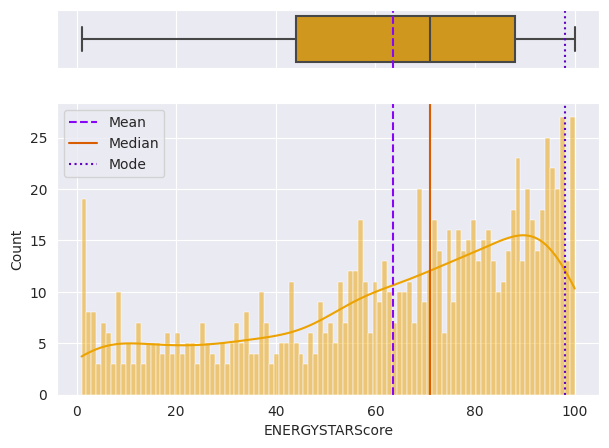

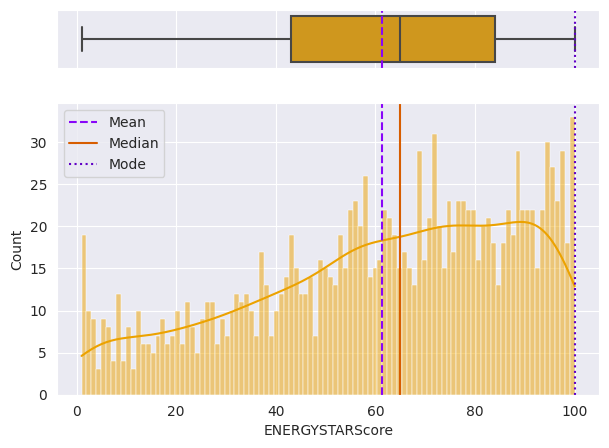

In [47]:
for df in [
    build_ener_df.loc[~build_ener_df["ENERGYSTARScore"].isna()].astype(
        {"ENERGYSTARScore": "int"}
    ),
    build_ener_dfs["ENERGYSTARScore NaNs imputed"],
]:
    f, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, figsize=(7, 5), gridspec_kw={"height_ratios": (0.2, 1)}
    )
    mean = df["ENERGYSTARScore"].mean()
    median = df["ENERGYSTARScore"].median()
    mode = df["ENERGYSTARScore"].mode().values[0]
    theme_clrs = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    sns.set_palette("gnuplot")
    sns.set_style("darkgrid")
    sns.boxplot(data=df, x="ENERGYSTARScore", ax=ax_box, color=theme_clrs[5])
    ax_box.axvline(mean, color=theme_clrs[1], linestyle="--")
    ax_box.axvline(mode, color=theme_clrs[0], linestyle=":")
    sns.histplot(
        data=df,
        x="ENERGYSTARScore",
        ax=ax_hist,
        bins=100,
        kde=True,
        color=theme_clrs[5],
    )
    ax_hist.axvline(mean, color=theme_clrs[1], linestyle="--", label="Mean")
    ax_hist.axvline(median, color=theme_clrs[4], linestyle="-", label="Median")
    ax_hist.axvline(mode, color=theme_clrs[0], linestyle=":", label="Mode")
    ax_hist.legend()
    ax_box.set(xlabel="")
    plt.show()


## Construction d'un pipeline de prétraitement <a class="anchor" id="constr_pipe"></a>
* Plusieurs fonctions sont définies puis combinées pour le traitement des caractéristiques d'entrée / matrices de variables indépendantes, dont :
    * Une fonction qui supprime les caractéristiques qui ne seront pas disponibles pour les prévisions futures : celles relatives aux émissions et à la consommation d'énergie
    * Une fonction qui normalise les caractéristiques continues à l'aide d'un scaler min-max
    * Une fonction qui applique l'encodage one-hot aux caractéristiques catégorielles

In [48]:
contin_feats = [
    "Latitude",
    "Longitude",
    "YearBuilt",
    "NumberofBuildings",
    "NumberofFloors",
    "PropertyGFATotal",
    "PropertyGFAParking",
    "PropertyGFABuilding(s)",
    "LargestPropertyUseTypeGFA",
    "SecondLargestPropertyUseTypeGFA",
    "ThirdLargestPropertyUseTypeGFA",
    "ENERGYSTARScore",
]
categ_feats = [
    "BuildingType",
    "PrimaryPropertyType",
    "ZipCode",
    "CouncilDistrictCode",
    "Neighborhood",
    "LargestPropertyUseType",
    "SecondLargestPropertyUseType",
    "ThirdLargestPropertyUseType",
]
mm_scaler = MinMaxScaler(feature_range=(0, 1))


def remove_unusable(df):
    for col_name in [
        x for x in df.columns.to_list() if x not in contin_feats + categ_feats
    ]:
        df = df.drop(col_name, axis=1)

    return df


def normalize_contin(df):
    cf_lst = [x for x in df.columns.to_list() if x in contin_feats]

    with pd.option_context("mode.chained_assignment", None):
        df[cf_lst] = mm_scaler.fit_transform(df[cf_lst].to_numpy())

    return df


def one_hot_categs(df):
    for col_name in [x for x in df.columns.to_list() if x in categ_feats]:
        df = pd.concat(
            [df, pd.get_dummies(df[col_name], prefix=col_name)], axis=1
        ).drop(col_name, axis=1)

    return df


def preproc_pipe(df, normalize=True):
    if normalize:
        return (
            df.copy().pipe(remove_unusable).pipe(normalize_contin).pipe(one_hot_categs)
        )
    else:
        return df.copy().pipe(remove_unusable).pipe(one_hot_categs)


## Utilisation d'un régresseur factice pour établir des indicateurs de base de référence<a class="anchor" id="reg_factice"></a>
* Une fonction est définie qui renvoie les indicateurs validées croisées suivantes :
    * Score R2 (Coefficient de détermination):
        * Définition des termes :
            * Somme des carrés totale (SCT) : La somme des différences au carré entre les valeurs réelles et leur moyenne (variance totale)
            * Somme des carrés des résidus (SCR) : La somme des différences au carré entre les valeurs réelles et prédites (variance inexpliquée)
        * Définition simple :
            * La proportion de la variation de la variable dépendante qui est prévisible à partir de la variable indépendante
        * Formule :
            * Variance expliquée / Variance totale = (SCT - SCR) / SCT
                * R2 calculé de cette manière donne un score compris entre 0 et 1, correspondant à une précision de prédiction de 0 % à 100 %
                * Scikit-learn permet le calcul de R2 pour des modèles autres que la régression linéaire en comparant l'adaptation (fit) d'un modèle à celui d'une ligne droite horizontale (l'hypothèse nulle). Cela peut entraîner un R2 négatif, qui indique simplement que le modèle ne suit pas la tendance des données.
        * Utilité :
            * Idéal pour la comparaison de modèles. Un R2 plus proche de 1 est meilleur, alors que des valeurs négatives sont très mauvaises
    * Score R2 ajusté :
        * Un problème avec R2 est que même lors de l'ajout de variables indépendantes redondantes aux données, la valeur de R2 ne diminue pas, mais reste la même ou augmente avec l'ajout de nouvelles variables indépendantes. R2 ajusté compense cela, ce qui permet de comparer des modèles avec des nombres différents de variables indépendantes.
    * Racine de l'erreur quadratique moyenne (RMSE) :
        * Explication :
            * Une estimation de l'écart type des résidus (erreurs de prédiction). Il n'utilise pas la racine carrée de la variance comme l'écart type, mais plutôt la racine carrée de la moyenne des résidus au carré. Étant donné que les erreurs sont mises au carré avant d'être moyennées, la RMSE donne un poids relativement élevé aux grandes erreurs (une erreur de 10 est 100 fois pire qu'une erreur de 1). Il fournit une erreur de prédiction moyenne du modèle en unités de la variable d'intérêt et sera toujours supérieur ou égal à la MAE.
        * Utilité :
            * Bon pour évaluer la performance d'un modèle tout en pénalisant les erreurs les plus importantes, moins c'est mieux.
    * Erreur absolue moyenne (MAE) :
        * Explication :
            * Une moyenne simple de la valeur absolue des résidus, c'est-à-dire la distance moyenne entre une prédiction et la valeur réelle dans les unités de la variable cible avec toutes les erreurs pondérées de manière égale.
        * Utilité :
            * Bon pour évaluer la performance d'un modèle dans les unités cibles réelles, moins c'est mieux.
        * Remarques :
            * Une plus petite différence entre RMSE et MAE est meilleure, indiquant moins de variance dans les erreurs.
* Les émissions de gaz à effet de serre sont définies comme cible (variable dépendante) pour toutes les prévisions suivantes.
* Un régresseur factice est utilisé pour calculer des indicateurs de base de référence, qui sont ensuite affichés.

In [49]:
def get_metrics(model, X, y):
    n = len(X)
    p = len(X.columns)
    r2 = cross_val_score(model, X=X, y=y, scoring="r2").mean()
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    rmse = abs(
        cross_val_score(model, X=X, y=y, scoring="neg_root_mean_squared_error").mean()
    )
    mae = abs(
        cross_val_score(model, X=X, y=y, scoring="neg_mean_absolute_error").mean()
    )

    return {
        "R^2": r2,
        "Adjusted R^2": r2_adj,
        "RMSE": rmse,
        "MAE": mae,
    }


target = build_ener_df["TotalGHGEmissions"]
dummy_metrics = {}

for build_ener_df_str in build_ener_dfs.keys():
    dummy_metrics[build_ener_df_str] = get_metrics(
        DummyRegressor(), preproc_pipe(build_ener_dfs[build_ener_df_str]), target
    )

display(dummy_metrics)


{'ENERGYSTARScore NaNs replaced by median': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.35816529338446923,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'ENERGYSTARScore NaNs replaced by negative scores': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.35816529338446923,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'ENERGYSTARScore NaNs imputed': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.35816529338446923,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'ENERGYSTARScore with one-hot encoding': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.3570770199122062,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662},
 'No ENERGYSTARScore used': {'R^2': -0.12758463438777187,
  'Adjusted R^2': -0.3570770199122062,
  'RMSE': 698.8087138011664,
  'MAE': 243.21632791380662}}

## Remarques sur les fuites de données <a class="anchor" id="ramarq_fuit_donn"></a>
* Une fuite de données se produit lorsqu'un ensemble d'apprentissage contient des données qui ne sont pas disponibles en production. Par conséquent, même si la précision de la validation peut sembler élevée, les prédictions du monde réel ont tendance à être pires que prévu. Une autre forme plus subtile est lorsqu'un modèle correspond trop étroitement à son ensemble de données d'apprentissage, ce qui entraîne ce que l'on appelle un surajustement, qui conduit également à des métriques de validation favorables et à de mauvaises prédictions en production.
* Stratégies pour l'éviter :
    * Ne donnant pas au modèle l'accès à des données qui ne seront pas disponibles dans les prévisions du monde réel, comme dans cette analyse, qui vise à prédire les émissions de gaz à effet de serre, les statistiques d'utilisation de l'énergie sont exclues des données d'apprentissage car elles sont fortement corrélées aux émissions, et ne seront probablement pas disponibles pour les prévisions futures.
    * Réserver un ensemble de validation qui est séparé des données d'apprentissage à utiliser pour l'évaluation finale du modèle.
    * Utilisation de la validation croisée (expliquée à l'étape suivante de l'analyse) lors de la sélection des caractéristiques et du réglage des hyperparamètres pour atténuer les mesures de performances biaisées.

## Création des fonctions pour la sélection automatique des caractéristiques <a class="anchor" id="sel_auto_caract"></a>
* Définitions :
    * Élimination récursive de caractéristiques : un algorithme qui accepte un modèle et un nombre souhaité de caractéristiques, puis il supprime séquentiellement chaque fonctionnalité, test à chaque fois la précision du modèle, puis supprime définitivement la fonctionnalité dont la suppression a eu l'impact le plus positif sur l'ajustement du modèle fourni. Le processus est répété jusqu'à ce qu'il reste le nombre souhaité de caractéristiques.
    * Validation croisée : méthode consistant à diviser un ensemble de données en un certain nombre de parties égales et, sur le même nombre d'itérations, à utiliser chaque segment comme ensemble de test et les segments restants comme ensembles d'apprentissage, puis à faire la moyenne des résultats.
    
        <div><img src="cross_val.png" width="700"/></div>
    * Grid Search : un algorithme de recherche exhaustif qui prend en compte une plage de valeurs proposées pour chaque hyperparamètre à régler, teste toutes les permutations possibles des valeurs et renvoie les valeurs optimales selon la méthode de notation définie.
* Les fonctions :
    * Une qui renvoie les caractéristiques continues qui permettent les prédictions les plus précises possibles
        * Accepte un modèle de régression, une matrice de variables indépendantes et un tableau de variables dépendantes.
        * Effectue un grid search validée croisée sur un estimateur de sélection de caractéristiques récursives pour le modèle de régression fourni en utilisant entre une et toutes les caractéristiques continues possibles et en évaluant en fonction du score R2.
        * Répète l'élimination récursive des caractéristiques en commençant par le nombre de fonctionnalités renvoyées par le grid search et en en ajoutant une par une jusqu'à ce que la performance diminue, mais cette fois en basant l'évaluation sur le score R2 ajusté.
        * Renvoie les caractéristiques continu de support donnant le meilleur score R2 ajusté.
    * Une qui renvoie les caractéristiques catégorielles de support
        * Renvoie les caractéristiques de support sélectionnées par l'élimination récursive de caractéristiques validée croisée basée sur l'évaluation R2.
        * Moins complexe que l'approche des caractéristiques continues en raison des contraintes de calcul.
    * Une qui renvoie les résultats combinés des deux fonctions précédemment définies
    * Une qui renvoie des jeux d'entraînement et de test prétraités et filtrés pour les caractéristiques de support
        * Accepte un modèle de régression, une matrice de variables indépendantes, un tableau de variables dépendantes et des arguments de mot-clé pour "train test split".
        * Le but de cette fonction est de faire en sorte que les matrices de variables indépendantes pour l'ensemble d'apprentissage et de test contiennent toutes les mêmes caractéristiques en réinsérant les caractéristiques encodées "one-hot" manquantes, car la sélection automatisée des caractéristiques a tendance à aboutir à un ensemble de caractéristiques catégorielles disparates.
    * Une qui renvoie les caractéristiques de support sélectionnées sur un nombre défini d'itérations avec un seuil de pourcentage.
        * La sélection de caractéristiques automatisée est répétée un nombre défini de fois, et si une caractéristiques est présente dans un pourcentage choisi des ensembles de caractéristiques de support générées, elle est ajoutée à l'ensemble de retour.


In [50]:
def get_contin_support_feats(estimator, X, y):
    rfe = RFE(estimator)
    grd_srch = GridSearchCV(
        estimator=rfe,
        param_grid={"n_features_to_select": list(range(1, len(contin_feats) + 1))},
        scoring="r2",
        cv=5,
    )
    X = preproc_pipe(X)[[x for x in X.columns if x in contin_feats]]

    grd_srch.fit(X, y)

    n_feats = grd_srch.best_params_["n_features_to_select"]
    adj_r2 = float("-inf")
    support_feats = []

    while n_feats <= len(contin_feats):
        rfe = RFE(estimator, n_features_to_select=n_feats)

        rfe.fit(X, y)

        new_support_feats = list(X.columns[rfe.support_])
        new_adj_r2 = get_metrics(estimator, X[new_support_feats], y)["Adjusted R^2"]

        if new_adj_r2 <= adj_r2:
            break
        else:
            n_feats += 1
            adj_r2 = new_adj_r2
            support_feats = new_support_feats

    return support_feats


def get_categ_support_feats(estimator, X, y):
    rfecv = RFECV(estimator=estimator, scoring="r2")
    X = preproc_pipe(X)
    X = X[[x for x in X.columns if x not in contin_feats]]

    rfecv.fit(X, y)

    return list(X.columns[rfecv.support_])


def get_support_feats(estimator, X, y):
    return get_contin_support_feats(estimator, X, y) + get_categ_support_feats(
        estimator, X, y
    )


def get_preproc_train_test_w_support_feats(model, X, y, **tts_kwargs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, **tts_kwargs)
    support_feats = get_support_feats(model, X_train, y_train)
    X_train, X_test = [preproc_pipe(X_train), preproc_pipe(X_test)]

    for feat in [x for x in support_feats if x not in X_train.columns.to_list()]:
        X_train[feat] = 0

    for feat in [x for x in support_feats if x not in X_test.columns.to_list()]:
        X_test[feat] = 0

    X_train, X_test = [X_train[support_feats], X_test[support_feats]]

    return [X_train, X_test, y_train, y_test]


def get_freq_support_feats(model, rand_range=100, n_runs=3, perc_thresh=50):
    if 0 >= perc_thresh or perc_thresh > 100:
        raise Exception(
            "'perc_thresh' parameter must be greater than 0 and less than or equal to 100."
        )

    feat_lists = []
    feat_counts = {}
    freq_feats = []

    for random_seed in [random.randint(0, rand_range) for i in range(0, n_runs)]:
        for build_ener_df_str in build_ener_dfs.keys():
            X_train, X_test, y_train, y_test = get_preproc_train_test_w_support_feats(
                model,
                build_ener_dfs[build_ener_df_str],
                target,
                random_state=random_seed,
            )

            feat_lists += [X_train.columns.to_list()]

    for feat_list in feat_lists:
        for feat in feat_list:
            if feat in feat_counts:
                feat_counts[feat] += 1
            else:
                feat_counts[feat] = 1

    for feat in feat_counts.keys():
        if feat_counts[feat] / len(feat_lists) >= perc_thresh / 100:
            freq_feats += [feat]

    return freq_feats


## Modèle de régression linéaire <a class="anchor" id="mod_reg_lin"></a>
* An explanation of ordinary least squares regression:
    * A technique used to find the line of best fit for a set of data points in order to estimate the unknown parameters in a model. The method relies on minimizing the sum of squared residuals between the actual and predicted values. The sum of squared residuals is also termed the sum of squared errors (SSE).
        * yᵢ = α + βXᵢ + εᵢ
            * y → dependant variable
            * α → y-intercept
            * β → slope coefficient
            * X → independant variable
            * ε → squared residual
        <div><img src="ols_vis_formul.webp" width="600"/></div>
        * The previous graph shows an absolute error component. The following graph shows the use of squared errors:
        <div><img src="ols.png" width="400"/></div>
    * In the case of a bivariate dataset (one independant and one dependant variable) there is a best-fit line, but in a multivariate dataset (multiple independant variables) it becomes a best-fit hyperplane.
        <div><img src="multivar_ols.png" width="800"/></div>
    * The calculus method for minimizing the sum of squared residuals is take the partial derivative of the cost function (SSE) with respect to the coefficients of determination, set the partial derivatives equal to zero and solve for each of the coefficients.
        * The cost function is always convex regardless of the dataset.
            <div><img src="ols_cost_func.png" width="800"/></div>
    * Assumptions:
        * There is a linear relationship between the features X and target y
        * The residuals are normally distributed
        * The variance of the residual is constant/homogeneous (the dependant variable constitutes an atomic metric)
            * For example: If the dependant variable is height, and half the data points represent males and the other half females, but there is no male/female binary independant variable, though males tend to be taller, then the variance of heights would be heterogeneous.
            <div><img src="levene_test_en.png" width="400"/></div>
* What this does
    

In [51]:
if not os.path.isfile("lr_support_feats.pkl"):
    lr_support_feats = get_freq_support_feats(
        LinearRegression(), n_runs=6, perc_thresh=30
    )

    with open("lr_support_feats.pkl", "wb") as f:
        pickle.dump(lr_support_feats, f)
else:
    with open("lr_support_feats.pkl", "rb") as f:
        lr_support_feats = pickle.load(f)

print(lr_support_feats)

for build_ener_df_str in build_ener_dfs.keys():
    lr_model = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(
        preproc_pipe(build_ener_dfs[build_ener_df_str])[lr_support_feats],
        target,
        random_state=0,
    )
    lr_model.fit(X_train, y_train)
    metrics = get_metrics(lr_model, X_test, y_test)

    print(f"{build_ener_df_str}")

    for metric in metrics.keys():
        print(
            f"\tDummy {metric}: {dummy_metrics[build_ener_df_str][metric]}\n\t{metric}: {metrics[metric]}"
        )


['LargestPropertyUseTypeGFA', 'BuildingType_NonResidential', 'BuildingType_Nonresidential COS', 'BuildingType_Nonresidential WA', 'BuildingType_SPS-District K-12', 'PropertyGFATotal', 'LargestPropertyUseType_Self-Storage Facility']
ENERGYSTARScore NaNs replaced by median
	Dummy R^2: -0.12758463438777187
	R^2: -0.5450415800777502
	Dummy Adjusted R^2: -0.35816529338446923
	Adjusted R^2: -0.5744309579596638
	Dummy RMSE: 698.8087138011664
	RMSE: 508.6836690012036
	Dummy MAE: 243.21632791380662
	MAE: 194.34927142687462
ENERGYSTARScore NaNs replaced by negative scores
	Dummy R^2: -0.12758463438777187
	R^2: -0.5450415800777502
	Dummy Adjusted R^2: -0.35816529338446923
	Adjusted R^2: -0.5744309579596638
	Dummy RMSE: 698.8087138011664
	RMSE: 508.6836690012036
	Dummy MAE: 243.21632791380662
	MAE: 194.34927142687462
ENERGYSTARScore NaNs imputed
	Dummy R^2: -0.12758463438777187
	R^2: -0.5450415800777502
	Dummy Adjusted R^2: -0.35816529338446923
	Adjusted R^2: -0.5744309579596638
	Dummy RMSE: 698.8

In [52]:
if not os.path.isfile("dt_support_feats.pkl"):
    dt_support_feats = get_freq_support_feats(
        DecisionTreeRegressor(), n_runs=6, perc_thresh=30
    )

    with open("dt_support_feats.pkl", "wb") as f:
        pickle.dump(dt_support_feats, f)
else:
    with open("dt_support_feats.pkl", "rb") as f:
        dt_support_feats = pickle.load(f)

print(dt_support_feats)


['NumberofBuildings', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'BuildingType_Campus', 'BuildingType_NonResidential', 'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_Laboratory', 'PrimaryPropertyType_Large Office', 'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other', 'PrimaryPropertyType_Senior Care Community', 'PrimaryPropertyType_Small- and Mid-Sized Office', 'PrimaryPropertyType_Supermarket / Grocery Store', 'ZipCode_98101.0', 'ZipCode_98104.0', 'ZipCode_98109.0', 'ZipCode_98118.0', 'ZipCode_98121.0', 'ZipCode_98122.0', 'ZipCode_98125.0', 'ZipCode_98133.0', 'CouncilDistrictCode_1', 'CouncilDistrictCode_2', 'CouncilDistrictCode_3', 'CouncilDistrictCode_7', 'Neighborhood_DELRIDGE', 'Neighborhood_EAST', 'Neighborhood_LAKE UNION', 'Neighborhood_MAGNOLIA / QUEEN ANNE', 'Neighborhood_NORTHEAST', 'LargestPropertyUseType_Courthouse', 'LargestPropertyUseT

In [53]:
if not os.path.isfile("grd_srch_cv_dtr.pkl"):
    dt_hyperparams = {
        "criterion": ["squared_error", "absolute_error"],
        "splitter": ["best", "random"],
        "max_depth": [2, 4, 8, 16, None],
        "min_samples_split": [2, 4, 8, 16],
        "min_samples_leaf": [1, 2, 4, 8],
        "min_weight_fraction_leaf": [0, 0.2, 0.4],
        "max_features": ["log2", "sqrt", None],
        "max_leaf_nodes": [20, 40, 60, 80, 100, None],
    }

    grd_srch_cv_dtr = GridSearchCV(DecisionTreeRegressor(), dt_hyperparams, cv=5)

    grd_srch_cv_dtr.fit(
        preproc_pipe(build_ener_dfs["ENERGYSTARScore NaNs imputed"])[dt_support_feats],
        target,
    )

    with open("grd_srch_cv_dtr.pkl", "wb") as f:
        pickle.dump(grd_srch_cv_dtr, f)
else:
    with open("grd_srch_cv_dtr.pkl", "rb") as f:
        grd_srch_cv_dtr = pickle.load(f)

dtr_model = DecisionTreeRegressor(**grd_srch_cv_dtr.best_params_)

print(dummy_metrics["ENERGYSTARScore NaNs imputed"])
print(
    get_metrics(
        dtr_model,
        preproc_pipe(build_ener_dfs["ENERGYSTARScore NaNs imputed"])[dt_support_feats],
        target,
    )
)


{'R^2': -0.12758463438777187, 'Adjusted R^2': -0.35816529338446923, 'RMSE': 698.8087138011664, 'MAE': 243.21632791380662}
{'R^2': 0.2238547924636837, 'Adjusted R^2': 0.1415536806188903, 'RMSE': 555.1261104237835, 'MAE': 159.48254106312294}


In [54]:
def get_validation_metrics(X_test, y_test, y_pred):
    n = len(X_test)
    p = len(X_test.columns)
    r2 = r2_score(y_test, y_pred=y_pred)
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    rmse = mean_squared_error(y_test, y_pred=y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred=y_pred)

    return {
        "R^2": r2,
        "Adjusted R^2": r2_adj,
        "RMSE": rmse,
        "MAE": mae,
    }


X_train, X_test, y_train, y_test = train_test_split(
    preproc_pipe(build_ener_dfs["ENERGYSTARScore NaNs imputed"])[dt_support_feats],
    target,
)

dtr_model.fit(X_train, y_train)

y_pred = dtr_model.predict(X_test)

print(dummy_metrics["ENERGYSTARScore NaNs imputed"])
print(get_validation_metrics(X_test, y_test, y_pred))


{'R^2': -0.12758463438777187, 'Adjusted R^2': -0.35816529338446923, 'RMSE': 698.8087138011664, 'MAE': 243.21632791380662}
{'R^2': 0.2335293370573931, 'Adjusted R^2': -0.2442705567250112, 'RMSE': 283.77006196980284, 'MAE': 105.94885638297873}


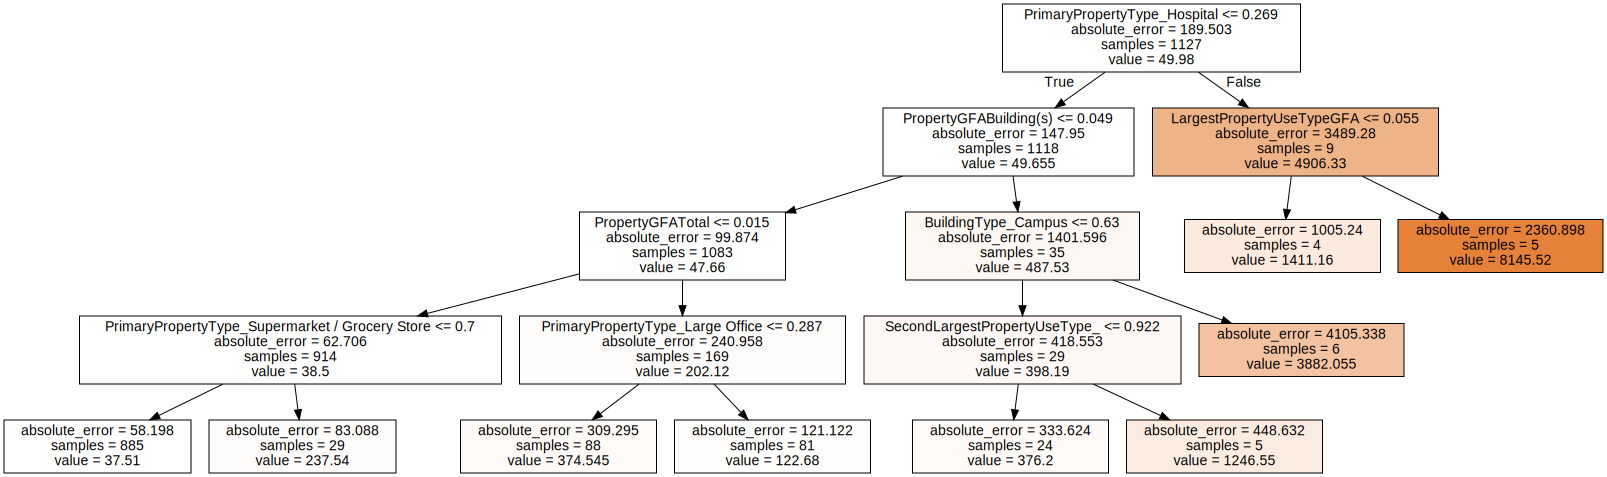

In [55]:
dot_data = export_graphviz(
    dtr_model, out_file=None, feature_names=X_train.columns, filled=True
)

graphviz.Source(dot_data, format="png")


In [56]:
if not os.path.isfile("grd_srch_cv_rfr.pkl"):
    rfr_model = RandomForestRegressor(
        **{
            key: value
            for key, value in grd_srch_cv_dtr.best_params_.items()
            if key != "splitter"
        }
    )
    rfr_hyperparams = {"n_estimators": [50, 100, 200, 300, 400, 500]}
    grd_srch_cv_rfr = GridSearchCV(rfr_model, rfr_hyperparams, cv=5)

    grd_srch_cv_rfr.fit(
        preproc_pipe(build_ener_dfs["ENERGYSTARScore NaNs imputed"])[dt_support_feats],
        target,
    )

    with open("grd_srch_cv_rfr.pkl", "wb") as f:
        pickle.dump(grd_srch_cv_rfr, f)
else:
    with open("grd_srch_cv_rfr.pkl", "rb") as f:
        grd_srch_cv_rfr = pickle.load(f)

display(grd_srch_cv_rfr.best_params_)


{'n_estimators': 100}

In [57]:
if not os.path.isfile("rfr_metrics.pkl"):
    n_runs = 50
    rfr_model = RandomForestRegressor(
        **{
            key: value
            for key, value in grd_srch_cv_dtr.best_params_.items()
            if key != "splitter"
        },
        **grd_srch_cv_rfr.best_params_
    )
    rfr_metrics = {
        "With ENERGYSTARScore": {"RMSE": [], "MAE": []},
        "Without ENERGYSTARScore": {"RMSE": [], "MAE": []},
    }

    for i in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(
            preproc_pipe(build_ener_dfs["ENERGYSTARScore NaNs imputed"])[
                dt_support_feats
            ],
            target,
        )

        rfr_model.fit(X_train, y_train)

        y_pred = rfr_model.predict(X_test)
        val_metrics = get_validation_metrics(X_test, y_test, y_pred)
        rfr_metrics["With ENERGYSTARScore"]["RMSE"] += [val_metrics["RMSE"]]
        rfr_metrics["With ENERGYSTARScore"]["MAE"] += [val_metrics["MAE"]]

        X_train, X_test = [
            X_train.drop(["ENERGYSTARScore"], axis=1),
            X_test.drop(["ENERGYSTARScore"], axis=1),
        ]

        rfr_model.fit(X_train, y_train)

        y_pred = rfr_model.predict(X_test)
        val_metrics = get_validation_metrics(X_test, y_test, y_pred)
        rfr_metrics["Without ENERGYSTARScore"]["RMSE"] += [val_metrics["RMSE"]]
        rfr_metrics["Without ENERGYSTARScore"]["MAE"] += [val_metrics["MAE"]]

    with open("rfr_metrics.pkl", "wb") as f:
        pickle.dump(rfr_metrics, f)
else:
    with open("rfr_metrics.pkl", "rb") as f:
        rfr_metrics = pickle.load(f)


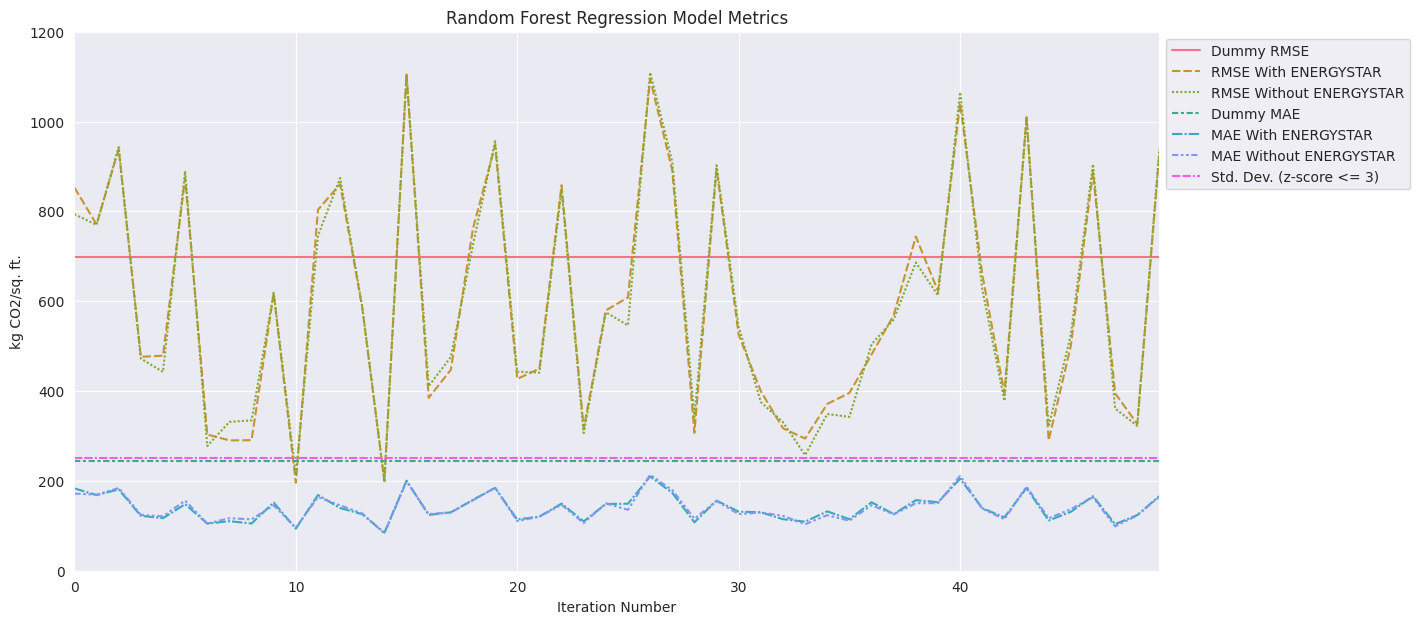

In [58]:
n_runs = len(rfr_metrics["With ENERGYSTARScore"]["RMSE"])
rfr_metrics_df = pd.DataFrame(
    {
        "Dummy RMSE": [dummy_metrics["ENERGYSTARScore NaNs imputed"]["RMSE"]] * n_runs,
        "RMSE With ENERGYSTAR": rfr_metrics["With ENERGYSTARScore"]["RMSE"],
        "RMSE Without ENERGYSTAR": rfr_metrics["Without ENERGYSTARScore"]["RMSE"],
        "Dummy MAE": [dummy_metrics["ENERGYSTARScore NaNs imputed"]["MAE"]] * n_runs,
        "MAE With ENERGYSTAR": rfr_metrics["With ENERGYSTARScore"]["MAE"],
        "MAE Without ENERGYSTAR": rfr_metrics["Without ENERGYSTARScore"]["MAE"],
        "Std. Dev. (z-score <= 3)": [
            target.copy()
            .drop(
                np.where(np.abs(stats.zscore(target)).to_numpy() > 3)[0].tolist(),
                axis=0,
            )
            .describe()["std"]
        ]
        * n_runs,
    }
)

sns.set_palette("gnuplot")
sns.set_style("darkgrid")

f, ax = plt.subplots(figsize=(14, 7))
rfr_lp = sns.lineplot(rfr_metrics_df, ax=ax)

rfr_lp.set_title("Random Forest Regression Model Metrics")
rfr_lp.set_xlabel("Iteration Number")
rfr_lp.set_ylabel("kg CO2/sq. ft.")
rfr_lp.set(xlim=(0, 49))
rfr_lp.set(ylim=(0, 1200))
rfr_lp.legend(bbox_to_anchor=(1, 1))
plt.show()


In [59]:
X = preproc_pipe(build_ener_df, normalize=False)
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.1)

if not os.path.isfile("rscv_xgb_reg.pkl"):
    xgb_regr = xgb.XGBRegressor(objective="reg:squarederror", nthread=4, seed=0)
    xgbr_hparams = {
        "n_estimators": [50, 100, 250, 500],
        "learning_rate": [0.1, 0.2, 0.3],
        "max_depth": [3, 4, 5, 6],
        "subsample": [0.5, 0.75, 1],
        "colsample_bytree": [0.5, 0.75, 1],
    }
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    kf = KFold(n_splits=5, random_state=0, shuffle=True)
    rscv_xgb_reg = RandomizedSearchCV(
        xgb_regr,
        param_distributions=xgbr_hparams,
        n_iter=200,
        scoring=scorer,
        cv=kf,
        n_jobs=4,
    )

    rscv_xgb_reg.fit(X_train, y_train)

    with open("rscv_xgb_reg.pkl", "wb") as f:
        pickle.dump(rscv_xgb_reg, f)
else:
    with open("rscv_xgb_reg.pkl", "rb") as f:
        rscv_xgb_reg = pickle.load(f)

print(rscv_xgb_reg.best_params_)


{'subsample': 0.5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.3, 'colsample_bytree': 0.5}


In [60]:
xgb_regr = xgb.XGBRegressor(
    objective="reg:squarederror", nthread=4, seed=0, **rscv_xgb_reg.best_params_
)

xgb_regr.fit(X_train, y_train)

y_pred = xgb_regr.predict(X_test)
y_pred[y_pred < 0] = target.describe()["min"]

print(get_validation_metrics(X_test, y_test, y_pred))


{'R^2': 0.9345181706132465, 'Adjusted R^2': 1.093545470552505, 'RMSE': 260.1673744590243, 'MAE': 114.15229953234555}


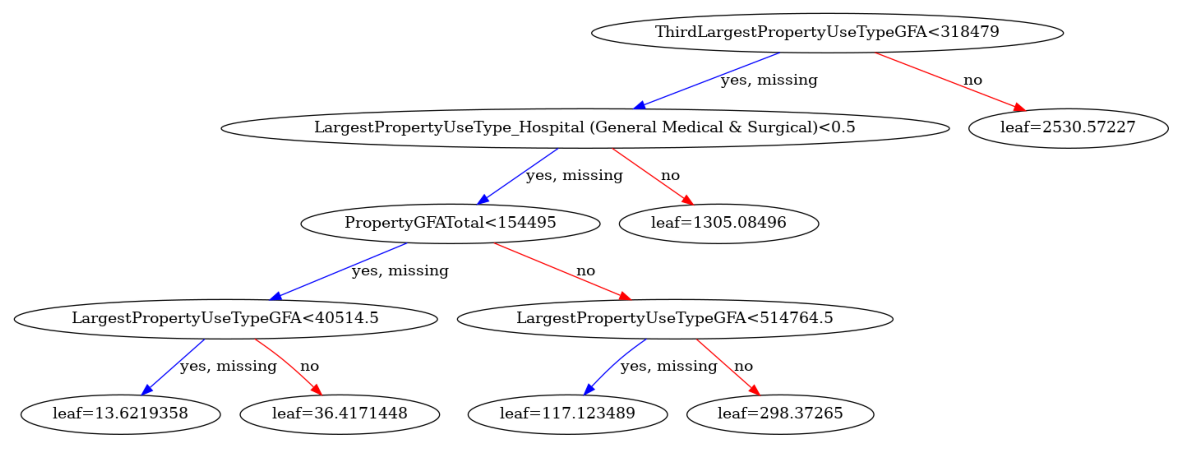

In [61]:
xgb.plot_tree(xgb_regr, num_trees=0)
plt.rcParams["figure.figsize"] = [15, 10]
plt.show()


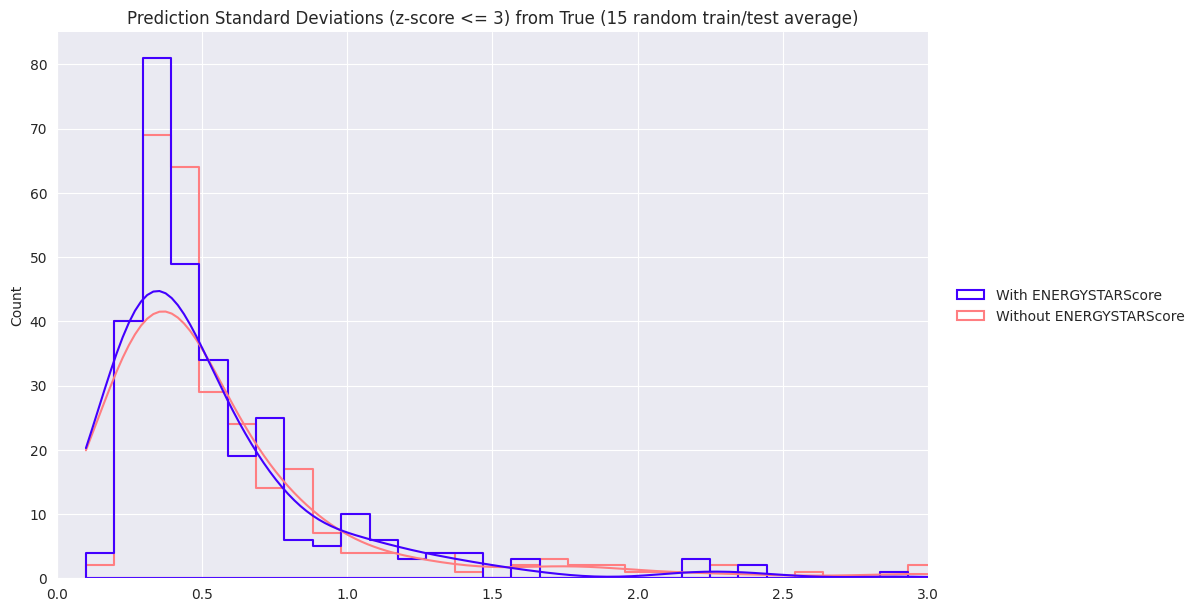

In [62]:
sdt_dev_no_outliers = (
    target.copy()
    .drop(
        np.where(np.abs(stats.zscore(target)).to_numpy() > 3)[0].tolist(),
        axis=0,
    )
    .describe()["std"]
)


def get_avg_std_devs_from_true(X, y, runs=10, test_size=0.2, **kwargs):
    std_devs_from_true = []

    if "rand_seeds" in kwargs.keys():
        rand_seeds = kwargs["rand_seeds"]
    else:
        rand_seeds = [random.randint(1, 500) for i in range(runs)]

    for i in range(runs):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=rand_seeds[i]
        )

        xgb_regr.fit(X_train, y_train)

        y_pred = xgb_regr.predict(X_test)
        y_pred[y_pred < 0] = target.describe()["min"]
        y_test = y_test.to_numpy()
        run_std_devs_from_true = []

        for i in range(len(y_pred)):
            abs_diff = abs(y_pred[i] - y_test[i])

            run_std_devs_from_true += [round(abs_diff / sdt_dev_no_outliers, 1)]

        std_devs_from_true += [run_std_devs_from_true]

    return [
        round(x / len(std_devs_from_true), 1)
        for x in np.sum(std_devs_from_true, axis=0)
    ]


runs = 15
test_size = 0.2
rand_seeds = [random.randint(1, 500) for i in range(runs)]
avg_std_devs_from_true = pd.DataFrame(
    {
        "With ENERGYSTARScore": get_avg_std_devs_from_true(
            X, y, runs=runs, test_size=test_size, rand_seeds=rand_seeds
        ),
        "Without ENERGYSTARScore": get_avg_std_devs_from_true(
            X.copy().drop(["ENERGYSTARScore"], axis=1),
            y,
            runs=runs,
            test_size=test_size,
            rand_seeds=rand_seeds,
        ),
    }
)

pred_hp = sns.displot(
    avg_std_devs_from_true,
    bins=int(round(max(avg_std_devs_from_true.max().to_list()), 1) * 10),
    kde=True,
    height=6,
    element="step",
    lw=1.5,
    aspect=1.6,
    alpha=0.0,
    palette="gnuplot2",
)

pred_hp.set(xlim=(0, 3))
plt.title(
    f"Prediction Standard Deviations (z-score <= 3) from True ({runs} random train/test average)"
)
plt.show()
